# Description
This will focus on time series analysis. 
From the learned betas, I will do further analysis of how the infered variables vary by region, etc.

#### NOTE: As described in EDA notebook, "Pseudo_ts" is concatenation of data from locally adjacent ski resorts (e.g., all resorts in Colorado) into a single timeseries.
# Imports

In [1]:
# data wrangling
import numpy as np
import pandas as pd
import os.path

# viz
import altair as alt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# modeling
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as smt
import statsmodels.graphics as smg

%load_ext autoreload
%autoreload 2
# project code
from project_utils.project_utils import *

# Parameters

In [2]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')
plt.rc('figure', figsize=(11.0, 7.0))

# Load Data

In [3]:
all_data_path = r'../../data/snow_data_clean.parquet'

In [4]:
long_series_df = pd.read_parquet(all_data_path).reset_index().set_index('pseudo_ts')
assert long_series_df.base.isna().sum()==0
month_ts_df = long_series_df.pipe(resample_by_month, time_col='pseudo_ts')
# start analysis with just CO resorts
co_base_ts = (month_ts_df
              .query('state=="colorado"')
              #.pipe(index_setter, freq='MS')
              .sort_values(by='pseudo_ts')
              .dropna(how='all')
             )

# Plotting Functions
* ACF, PACF, etc.  
* residuals over time
* y vs yhat
* train & extrapolate



In [5]:
def y_and_yhat_plotter(model=None, data=None, test_data=None, steps=5, start_skip=1):
    """plots values and model predictions
    Inputs:
        model: a fit model
        data: df with time series data and pseudo_ts index
        test_data: out of sample data
        exog_col: column name
        steps: steps out to predict"""
    # copy for both plots
    model_multi = model
    df = multi_df = data.copy().rename(columns={'base': 'y'})
    test_df = test_multi_df = test_data.copy().rename(columns={'base': 'y'})
    
    #get prediction for both train & test
    df = pd.concat([df, test_df], axis=0)
    
    df['yhat'] = model.predict(df, steps=1, include_ci=True, dynamic=False)
    df['lowerCI'] = model.prediction_ci.iloc[:, 0]
    df['upperCI'] = model.prediction_ci.iloc[:, 1]
    test_multi_df['yhat'] = model_multi.predict(test_multi_df, steps=steps, 
                        include_ci=True, dynamic=False)#(test_multi_df.shape[0]-1))
    test_multi_df['lowerCI'] = model_multi.prediction_ci.iloc[:, 0]
    test_multi_df['upperCI'] = model_multi.prediction_ci.iloc[:, 1]
    
    multi_df = pd.concat([multi_df, test_multi_df])

    # skip first value: predictions are based on prior values
    df2, multi2_df = df.iloc[start_skip:, :], multi_df.iloc[start_skip:, :]

    def melt_predicts(df):
        return (df
                .reset_index()
                .rename(columns={'index': 'pseudo_ts'})
                .melt(value_vars=['y', 'yhat'], id_vars=['pseudo_ts'])
                )
    melted_df2 = melt_predicts(df)
    melted_df_multi2 = melt_predicts(multi_df)

    fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True)

    def plot_sub(y, ci_data, axis):
        sns.lineplot(data=y, x='pseudo_ts', y='value', hue='variable',
                     marker='x', ax=axis)
        axis.fill_between(ci_data.index, ci_data.lowerCI,
                          ci_data.upperCI, alpha=.3)
    data = (df2, multi2_df)
    melted_data = (melted_df2, melted_df_multi2)
    for datum, melted_datum, axis in zip(data, melted_data, axes):
        plot_sub(y=melted_datum, ci_data=datum, axis=axis)
    axes[0].set_title("One Step Prediction over Train & Test")
    axes[1].set_title("Recursive Prediction on Test Set")

# Timeseries Modeling

The evolution of snow base depth over time depends (not 1:1; a foot of powder is only a few inches of packed powder) on new snowfall and melting of old snow. I will start by modeling as a simple timeseries, and then include new snowfall as a predictor variable.

## Modeling Setup
I will use supersetting crossvalidation (walk-forward CV) since this is a time series problem.

## ARIMA and extensions

<Figure size 792x504 with 0 Axes>

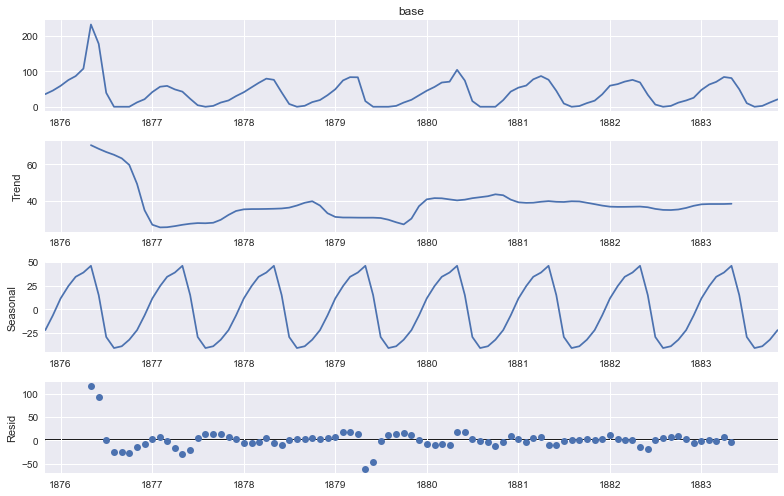

In [6]:
WP_train, WP_test = train_test_split(df=month_ts_df, station="Winter Park")
decomposition = smt.seasonal.seasonal_decompose(WP_train.base, period=12)
fig = plt.figure()
fig = decomposition.plot();

There is clear seasonality so I will specify a Seasonal autoregressive integrated moving average model. I will start with the combined timeseries for the Colorado ski mountains.

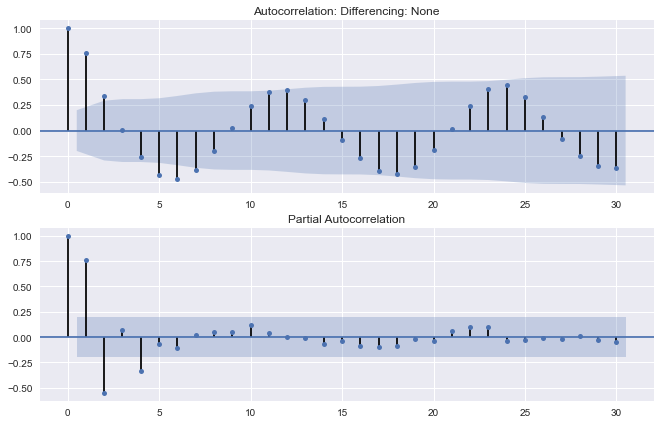

In [7]:
AC_PAC_plotter(WP_train)

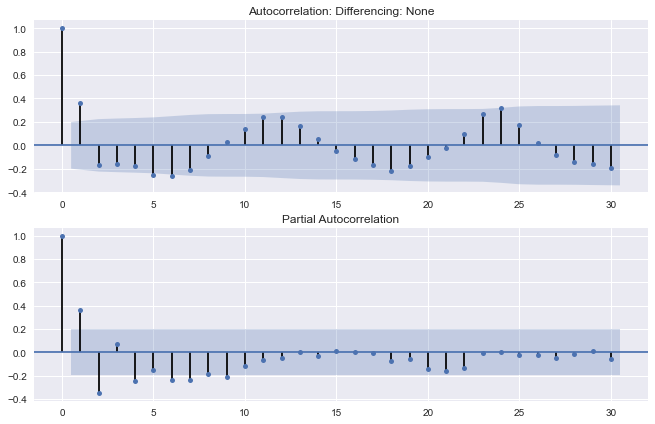

In [8]:
AC_PAC_plotter(WP_train.assign(base=lambda x: x.base.diff(periods=1)).fillna(0))

I will use differencing order of 1. There may be a trend do to sequence the mountains were concatenated in.
I will add one MA term because of the slight negative correlation on the differenced series on the first lag.

In [9]:
# try crossvalition on model 
# (p, d, q) | (AR, diff, MA) ; 
arima_model = SMWrapper(model_class=smt.arima.model.ARIMA, 
                        order=(0, 1, 1))

arima_model.fit(X=WP_train)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   base   No. Observations:                   97
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -438.932
Date:                Mon, 29 Jun 2020   AIC                            881.865
Time:                        02:08:55   BIC                            886.994
Sample:                    11-01-1875   HQIC                           883.938
                         - 11-01-1883                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5950      0.033     18.280      0.000       0.531       0.659
sigma2       545.6533     30.880     17.670      0.000     485.130     606.177
===================================================================================
Ljung-Box (Q):                       49.09   Jarque-Bera (JB):               622.00
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                            -0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

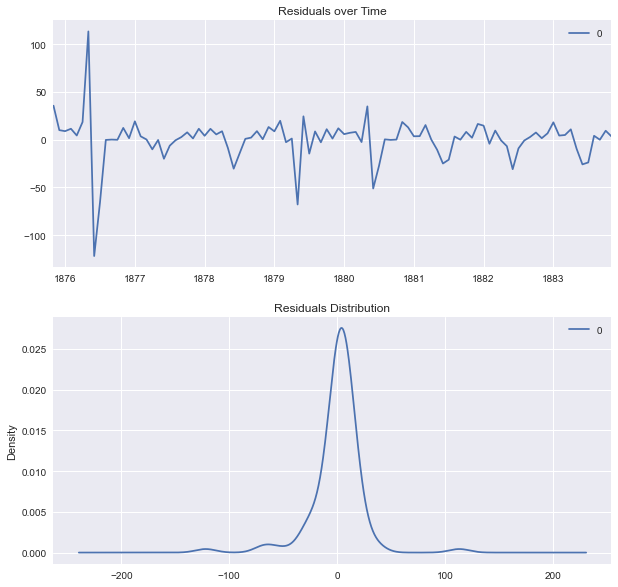

                0
count   97.000000
mean     0.299525
std     23.652201
min   -121.871490
25%     -2.462849
50%      2.778492
75%      8.978470
max    113.407677


In [10]:
arima_resids = pd.DataFrame(arima_model.resid)
resid_plotter(arima_resids)

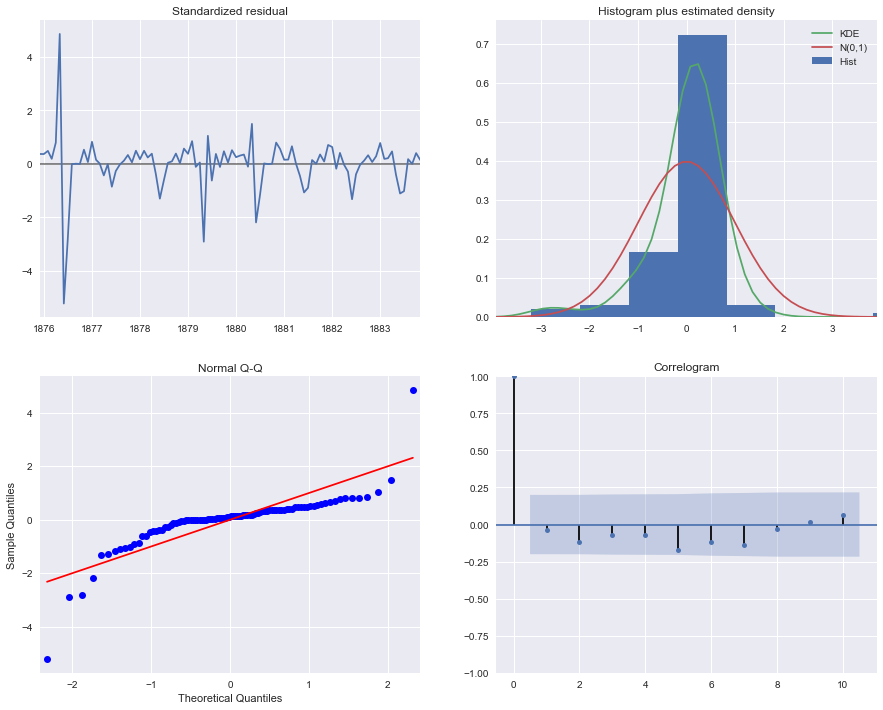

In [11]:
_ = arima_model.plot_diagnostics(figsize=(15, 12))

In [12]:
# could use full dataset for IC-based selection
IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=WP_train,  
           y=WP_train.shift(1), order_limit=(2, 0))\
.applymap((lambda x : "{:,.0f}".format(x)))

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,AIC,BIC
"(1, 0, 1)(1, 1, 1, 12)12",754,767
"(1, 0, 1)(1, 1, 0, 12)12",757,767
"(1, 0, 1)(0, 1, 1, 12)12",758,767
"(0, 0, 1)(0, 1, 1, 12)12",765,772
"(0, 0, 1)(1, 1, 0, 12)12",766,773
...,...,...
"(1, 0, 0)(0, 0, 0, 12)12",906,914
"(0, 0, 0)(1, 0, 1, 12)12",940,950
"(0, 0, 0)(1, 0, 0, 12)12",957,965
"(0, 0, 0)(0, 0, 1, 12)12",975,983


there does not appear to be a trend. The errors are not exactly normal. The residuals vary cyclicly so an ARCH  model may be useful.

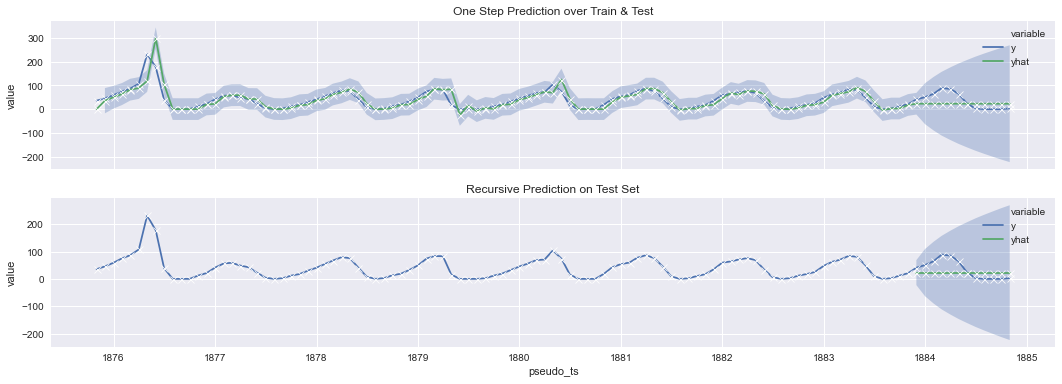

In [13]:
y_and_yhat_plotter(model=arima_model, data=WP_train, test_data=WP_test)

In [28]:
arima_cv_results = time_crossval(model=arima_model, X=WP_train, 
                                 y=WP_train.shift(1).fillna(0))
pd.DataFrame(arima_cv_results)

,fit_time,score_time,test_neg_root_mean_squared_error,test_r2,test_neg_mean_absolute_error
0,0.036896,0.004987,-40.114679,-3.204150,-35.020362
1,0.025931,0.005984,-29.609224,-0.030725,-25.870715
2,0.026927,0.005983,-36.706064,-0.259908,-28.764381
3,0.027925,0.005984,-55.693822,-2.351662,-46.651366
4,0.029887,0.009973,-47.950883,-1.348762,-36.336642
5,0.028926,0.006948,-46.541051,-2.084581,-39.475936
6,0.028922,0.007978,-53.228536,-2.542350,-45.093762
7,0.033935,0.007984,-35.324113,-0.270637,-29.270913


this looks somewhat over-dispersed.

### SARIMA
There should not be any relationship between years (absent modeling climate-level dependencies e.g. El Niño cycles, so I will do a simple 1 years differencing.

In [15]:
IC_results = IC_chooser(unwrapped_mod=smt.arima.model.ARIMA, X=WP_train,
                        y=WP_train.shift(1), order_limit=(2, 1))

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [16]:
IC_results.applymap(lambda x : "{:,.0f}".format(x))

,AIC,BIC
"(1, 0, 1)(1, 1, 1, 12)12",754,767
"(1, 0, 1)(1, 1, 0, 12)12",757,767
"(1, 0, 1)(0, 1, 1, 12)12",758,767
"(0, 0, 1)(0, 1, 1, 12)12",765,772
"(0, 0, 1)(1, 1, 0, 12)12",766,773
...,...,...
"(1, 0, 0)(0, 0, 0, 12)12",906,914
"(0, 0, 0)(1, 0, 1, 12)12",940,950
"(0, 0, 0)(1, 0, 0, 12)12",957,965
"(0, 0, 0)(0, 0, 1, 12)12",975,983


In [17]:
sarima_model = SMWrapper(model_class=smt.arima.model.ARIMA,  order=(0, 1, 1),
                         seasonal_order=(0, 1, 0, 12))
sarima_model.fit(WP_train)

In [18]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                              base   No. Observations:                   97
Model:             ARIMA(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -392.025
Date:                           Mon, 29 Jun 2020   AIC                            788.050
Time:                                   02:09:28   BIC                            792.912
Sample:                               11-01-1875   HQIC                           790.005
                                    - 11-01-1883                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4124      0.041     10.110      0.000       0.332       0.492
sigma2       661.0572     43.783     15.099      0.000     575.244     746.870
===================================================================================
Ljung-Box (Q):                       62.08   Jarque-Bera (JB):               283.52
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
sarima_cv_results = time_crossval(model=sarima_model, X=WP_train, 
                                  y=WP_train.shift(1).fillna(0))
pd.DataFrame(sarima_cv_results)

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:901: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:]**2).mean()
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1027: RuntimeWarning: invalid value encountered in less
  params_variance = np.atleast_1d(max(np.array(params_variance), 1e-10))
c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\base\mode

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

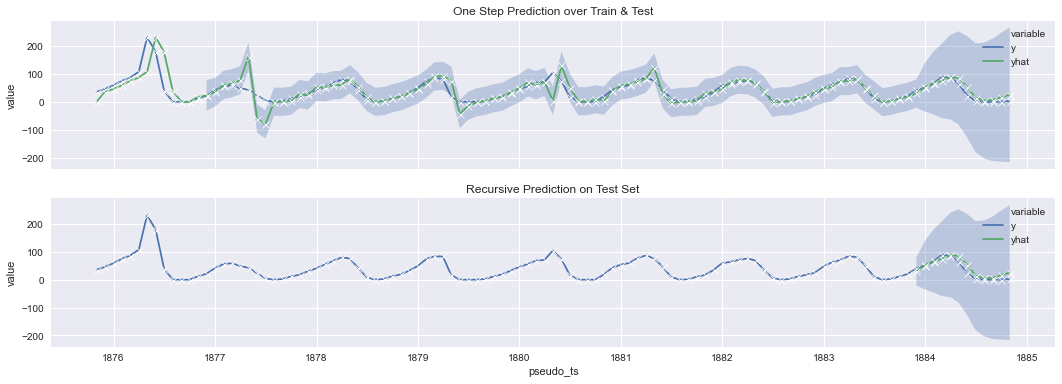

In [19]:
y_and_yhat_plotter(model=sarima_model, data=WP_train, test_data=WP_test, start_skip=13)

# Regression with SARIMA Errors
Similar to ARIMAX but with more interpretable coefficients.  
Pace the name, StatsModels actually implements Regression with SARIMA errors, not ARIMAX.  
using snowfall data with powder -> packed powder and melt inference

In [20]:
WP_trainx, WP_testx = train_test_split(df=month_ts_df,
                                       station="Winter Park", 
                                       exog_cols=['snowfall'])

In [21]:
reg_w_sarima = SMWrapper(model_class=smt.statespace.sarimax.SARIMAX,
                         order=(0, 1, 1), seasonal_order=(0, 1, 0, 12))

In [22]:
reg_w_sarima.fit(X=WP_trainx)

In [23]:
reg_w_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                base   No. Observations:                   97
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -391.229
Date:                             Mon, 29 Jun 2020   AIC                            788.458
Time:                                     02:09:29   BIC                            795.750
Sample:                                 11-01-1875   HQIC                           791.389
                                      - 11-01-1883                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
snowfall      -0.0866      0.118     -0.735      0.462      -0.317       0.144
ma.L1          0.4414      0.042     10.568      0.000       0.360       0.523
sigma2       648.4097     64.800     10.006      0.000     521.405     775.415
===================================================================================
Ljung-Box (Q):                       57.05   Jarque-Bera (JB):               237.03
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
y_and_yhat_plotter(model=reg_w_sarima, data=WP_trainx, test_data=WP_testx, start_skip=13)

ValueError: Provided exogenous values are not of the appropriate shape. Required (12, 1), got (0, 1).

In [25]:
snow_beta_df = (pd.DataFrame({'station': ['test'], 'beta': [0], 'region': ['test']})
                .drop(index=0))  # avoid pd forcing region column to numeric
month_reset = month_ts_df.reset_index(level=1)
for station in month_reset.station.unique():
    station_df = resample_by_month(month_reset[month_reset.station==station], 'pseudo_ts').reset_index(level=1)
    reg_w_sarima = smt.statespace.sarimax.SARIMAX(endog=station_df.base, 
                                                  exog=station_df.snowfall,
                                                  order=(0,1,1), 
                                                  seasonal_order=(0,1,0,12))
    results = reg_w_sarima.fit()
    snow_beta_df.at[station, 'beta'] = results.params.snowfall
    snow_beta_df.at[station, 'region'] = station_df.region[0]

c:\users\user\documents\github\ski-snow-modeling\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [26]:
snow_beta_df.head()

,station,beta,region
Big Squaw,NaN,-0.206543,New_England
Mt. Holiday,NaN,-0.692675,Other
Song Mountain,NaN,0.029599,East
Blue Hills,NaN,0.589103,New_England
Snowshoe,NaN,0.082373,East


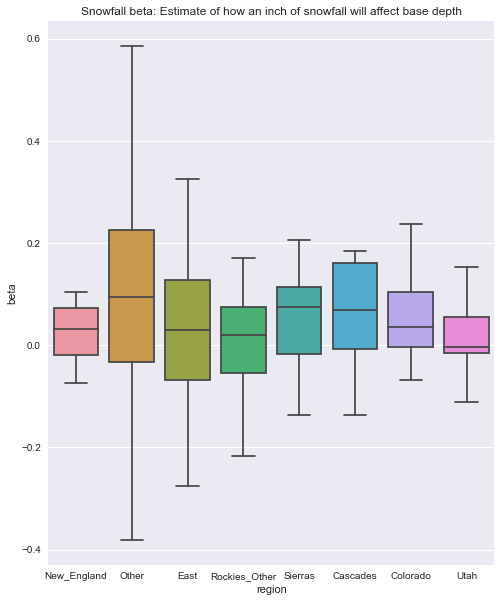

In [27]:
plt.figure(figsize=(8,10))
sns.boxplot(data=snow_beta_df, x='region', y='beta', showfliers=False)
plt.title('Snowfall beta: Estimate of how an inch of snowfall will affect base depth');

This shows the betas from the regression with SARIMA errors on the snowfall variable. This indicates how much base an inch of snow results in, after accounting for time series effect e.g. seasonal change. There is a fairly large amount of noise on this, but the results look broadly in line with my expectation: higher base from a given snowfall amount in the sierras & Cascades, which are known for 'wet' snow (high moisture/air ratio), as compared to dried climates like the Rockies. 

#### Other models
GARCH, Gaussian Process, hidden Markov

### Bayesian Structural Model
[example bsm in R](https://multithreaded.stitchfix.com/blog/2016/04/21/forget-arima/),  
[use tensorflow probability](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html),  
[tfp example notebook: link](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb), 

### Panel Models
Linearmodels module?